In [1]:
%matplotlib notebook
from ipywidgets import *

import rospy
import rospkg
import os.path

from mag_manip.mag_manip import *
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib import cm
import matplotlib as mpl
import numpy as np
from numpy.linalg import lstsq
from scipy.linalg import null_space
import math
import yaml

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np
from scipy.interpolate import griddata

from itertools import combinations
from scipy.spatial import ConvexHull

In [66]:
#Customized color bar 1

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 177/256, N)
vals[:, 1] = np.linspace(130/256, 78/256, N)
vals[:, 2] = np.linspace(180/256, 132/256, N)
newcmp = ListedColormap(vals)

#Customized color bar 2

vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 

vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)
cmp_blue_3col_inv = ListedColormap(cmp_blue_3col.colors[::-1])

# Workspace and analysis of 3d electromagnetic navigation systems

## Functions for feasibility test with zonotopes

Approach proposed in [Bouchard 2008](https://asmedigitalcollection.asme.org/mechanismsrobotics/article/2/1/011010/475593/On-the-Ability-of-a-Cable-Driven-Robot-to-Generate) to check if required field can be generated in one position. 

In [58]:
#Compute the vertices of the convex hull defining the zonotope
def ComputeZonotopeVertices(Imin,Imax,J):

    N = np.shape(J)[1]
    pts = np.stack(([0,1],)*N,0)
    A_alpha = np.transpose((np.array(np.meshgrid(*pts)).T).reshape(2**N,N)) #compute permutation matrix
    
    M = np.matmul(J,(Imax - Imin)*np.eye(N))
    C = np.matmul(M,A_alpha)
    
    hull = ConvexHull(np.transpose(C))
    hull_idx = hull.vertices
    C_hull = C[:,hull_idx]
    
    vert = np.transpose(C_hull + np.matmul(J,Imin*np.ones((N,1))))
    
    return vert

#Create permutation matrix for the selection of unitary actuation fields
def CreatePermuationMatrix(A):
    
    d = np.shape(A)[0] #dimension of output space (if field, this is 3)
    n = np.shape(A)[1] #number of coils
    
    comb = combinations(np.arange(n), d-1) 

    M = np.asarray(list(comb))  
    
    return M

#Create combination matrix to test combination of field
def CreateFieldCombinationMatrix(n):

    nums = np.arange(2**n)
    M = ((nums.reshape(-1,1) & (2**np.arange(n))) != 0).astype(int)
    
    return M

#Compute the hyperplane representation of the zonotope
def HyperPlaneShiftingMethod(A,Imin,Imax):
    
    dI = Imax - Imin
    M = CreatePermuationMatrix(A)
    nb_comb = np.shape(M)[0] #number of combination
    
    d = np.shape(A)[0] #dimension of output space (if field, this is 3)
    n_coils = np.shape(A)[1] #number of coils
    
    #Initialize matrix and vector for hyperplane representation
    N = np.zeros((2*nb_comb,d))
    d_vec = np.zeros((2*nb_comb,1))
    
    bmin = np.matmul(A,Imin*np.ones((n_coils,1)))
    
    #Iterate on the combination of unitary fields
    for i in range(nb_comb):
        
            
        # Step 1: define initial hyperplane
        
        #Define the set of vectors to be orthogonal with
        W = A[:,M[i,:]]
        
        #Get the orthogonal vector using the nullspace of W^T
        Wns = null_space(np.transpose(W))
        v = Wns[:,0]

        # Step 2: shift intial hyperplane
        temp = v / np.linalg.norm(v)
        n = temp.reshape((-1,1))
        
        # Step 3: build projections   
        lj_arr = np.zeros((n_coils-(d-1),1))
        k = 0
        h = 0. 
        for j in range(n_coils):
            if not(j in M[i,:]):
                lj = np.dot(np.transpose(A[:,j]),n)
                lj_arr[k,0] = lj
                k += 1

        C = CreateFieldCombinationMatrix(n_coils-(d-1))
        
        h = np.matmul(C,dI*lj_arr)
        
        hp = np.max(h)
        hm = np.min(h)
        
        #Step 4: compute hyperplane support
        pp = hp*n + bmin
        pm = hm*n + bmin
        
        
        # Step 5: build hyperplane representation
        N[i,:] = n.T
        N[i+nb_comb,:] = -n.T
        d_vec[i,:] = np.dot(n.T,pp)
        d_vec[i+nb_comb,:] = np.dot(-n.T,pm)
            
        
    return N, d_vec

#Check if a given task field set of the form of a convex polytope complies with the available field zonotope
#d, N is the hyperplane representation of the zonotope
#V contain the vertices of the polytope of the task field
def VerifyFeasabilityPolytope(d,N,V):
    
    D = np.repeat(d,np.shape(V)[1],axis=1)
    M = np.matmul(N,V) <= D
    isFeasible = np.all(M)
    
    return M, isFeasible

#Check if a given task field of the form of a point complies with the available field zonotope
#d, N is the hyperplane representation of the zonotope
#b contain the desired task field
def VerifyFeasabilityPoint(d,N,b):

    M = np.matmul(N,b) <= d
    isFeasible = np.all(M)
    
    return M, isFeasible

#Check if a given task field of the form of an ellipsoid complies with the available field zonotope
#d, N is the hyperplane representation of the zonotope
#a contain the half axes of the task field expressed as an ellipsoid
def VerifyFeasabilityEllipsoid(d,N,a):

    #Assume feasibility a priori
    isFeasible = True

    for i in range(N.shape[0]):
        
        n = np.transpose(N[i,:])
        kinv = 0
        
        for j in range(N.shape[1]):
            kinv = kinv + (a[j]*n[j])**2
            
        k = 1 / math.sqrt(kinv)
        
        e_p = np.matmul(np.diag(a**2)*k, n)
        e_m = np.matmul(-np.diag(a**2)*k, n)
        
        #Test feasibility in the directions of the ellipsoid normals colinear to the hyperplanes of the available set
        M, isFeasible_p = VerifyFeasabilityPoint(d,N,e_p)
        M, isFeasible_m = VerifyFeasabilityPoint(d,N,e_m)
        
        #Return false if at least one of the hyperplane is infeasible
        if not(isFeasible_p) or not(isFeasible_m):
            isFeasible = False
            break

    return isFeasible


def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

## Functions for evaluation metrics

In [31]:
def ComputeYoshikawaManipulability(A,amax): 

    if not np.shape(amax):
        amax_vec = np.repeat(amax, A.shape[0])
        S = np.diag(1/amax_vec)
    else:
        S = np.diag(1/amax)

    An = np.matmul(S,A)

    mu = np.sqrt(np.linalg.det(np.matmul(An,np.transpose(An))))

    return mu

def ComputeConditionNumber(A,amax):

    if not np.shape(amax):
        amax_vec = np.repeat(amax, A.shape[0])
        S = np.diag(1/amax_vec)
    else:
        S = np.diag(1/amax)

    An = np.matmul(S,A)

    u, s, v= np.linalg.svd(An)

    w_min  = np.min(s)
    w_max  = np.max(s)

    k = w_max/w_min

    return k



#Minimum distance to boundaries of the available set (depends on the desired task)
def MinDistanceToA(d,N,DesTask,task_type="polytope"):


    if task_type == "polytope":
        V = DesTask
        D = np.repeat(d,np.shape(V)[1],axis=1)
        M = D - np.matmul(N,V) 
        minDist = M.min()
    elif task_type == "point":
        b = DesTask
        D = d
        M = D - np.matmul(N,b)
        minDist = M.min()
    elif task_type == "ellipsoid":
        a = DesTask
        D = d
        minDist = 1e10 #high init of min dist
        
        for i in range(N.shape[0]):

            n = np.transpose(N[i,:])
            kinv = 0

            for j in range(N.shape[1]):
                kinv = kinv + (a[j]*n[j])**2

        k = 1 / math.sqrt(kinv)

        e_p = np.matmul(np.diag(a**2)*k, n)
        e_m = np.matmul(-np.diag(a**2)*k, n)

        M = D - np.matmul(N,e_p)
        if M.min() < minDist:
            minDist = M.min()
            
        M = D - np.matmul(N,e_m)
        if M.min() < minDist:
            minDist = M.min()
                
                
    else:
        print("The required type of task set does not exist!")
        return  


    return minDist

## Functions for workspace determination

In [29]:
#Compute the set of position where a task field set can be generated
#(require at least 3 coils)
def Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model_mns,task_type="polytope"):

    p_ws_in = np.empty((0,3))
    p_ws_out = np.empty((0,3))
    p_ws_side = np.empty((0,3))

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True)
    
        
    kappa = np.array([])
    mu = np.array([])
    minDist = np.array([])
    
    index_sum = 0
    total_pts = 0

    
    if task_type == "polytope":
        #Define task polytope
        V = np.transpose(bmin + (bmax-bmin)*CreateFieldCombinationMatrix(3))
    elif task_type == "ellipsoid":
        #Define task ellipse (circle)
        a = np.array([bmax, bmax, bmax])
    else:
        print("The required type of task set does not exist!")
        return
        
    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):        
                                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                J = model_mns.getFieldActuationMatrix(position)

                #Check feasibility at each grid point            
                N, d = HyperPlaneShiftingMethod(J,Imin,Imax)
                
                if task_type == "polytope":
                    M, isFeasible = VerifyFeasabilityPolytope(d,N,V)
                    DesTask = V
                elif task_type == "ellipsoid":
                    isFeasible = VerifyFeasabilityEllipsoid(d,N,a)
                    DesTask = a

                
                if isFeasible and np.linalg.matrix_rank(J) >= 3:
                    p_ws_in = np.append(p_ws_in, [position], axis=0)
                    mu_val = ComputeYoshikawaManipulability(J,bmax)
                    kappa_val = ComputeConditionNumber(J,bmax)
                    minDist_val = MinDistanceToA(d, N, DesTask, task_type)
                    mu = np.append(mu,[mu_val], axis=0)
                    kappa = np.append(kappa,[kappa_val], axis=0)
                    minDist = np.append(minDist,[minDist_val], axis=0)
                    index_sum += 1/kappa_val
                    total_pts += 1
                else:
                    p_ws_out = np.append(p_ws_out, [position], axis=0) 
                    
                if (x == pmin[0] or x == pmax[0]) and (y == pmin[1] or y == pmax[1]):
                    p_ws_side = np.append(p_ws_side, [position], axis=0)
                    
    gci = index_sum/total_pts
    
    return p_ws_in, p_ws_out, p_ws_side, kappa, mu, gci, minDist



#Compute the set of position where a task gradient set can be generated
#(require at least 5 coils)
def Ws3DGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,gmin,gmax,Imin,Imax,model_mns,task_type="polytope"):

    p_ws_in = np.empty((0,3))
    p_ws_out = np.empty((0,3))
    p_ws_side = np.empty((0,3))

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True)
    
    kappa = np.array([])
    mu = np.array([])
    minDist = np.array([])
    
    index_sum = 0
    total_pts = 0

    #Define task
    if task_type == "polytope":
        #Define task polytope
        V = np.transpose(gmin + (gmax-gmin)*CreateFieldCombinationMatrix(5))
    elif task_type == "ellipsoid":
        #Define task ellipse (circle)
        a = np.array([gmax, gmax, gmax, gmax, gmax])
    else:
        print("The required type of task set does not exist!")
        return
    
    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                Jtemp = model_mns.getActuationMatrix(position)
                J = Jtemp[3:8,:]

                #Check feasibility at each grid point            
                N, d = HyperPlaneShiftingMethod(J,Imin,Imax)
                
                if task_type == "polytope":
                    M, isFeasible = VerifyFeasabilityPolytope(d,N,V)
                    DesTask = V
                elif task_type == "ellipsoid":
                    isFeasible = VerifyFeasabilityEllipsoid(d,N,a)
                    DesTask = a

                if isFeasible and np.linalg.matrix_rank(J) >= 5:
                    p_ws_in = np.append(p_ws_in, [position], axis=0)
                    mu_val = ComputeYoshikawaManipulability(J,gmax)
                    kappa_val = ComputeConditionNumber(J,gmax)
                    minDist_val = MinDistanceToA(d, N, DesTask, task_type)
                    mu = np.append(mu,[mu_val], axis=0)
                    kappa = np.append(kappa,[kappa_val], axis=0)
                    minDist = np.append(minDist,[minDist_val], axis=0)
                    index_sum += 1/kappa_val
                    total_pts += 1
                else:
                    p_ws_out = np.append(p_ws_out, [position], axis=0) 
                    
                                
                if (x == pmin[0] or x == pmax[0]) and (y == pmin[1] or y == pmax[1]):
                    p_ws_side = np.append(p_ws_side, [position], axis=0)
                    
    gci = index_sum/total_pts
    
    return p_ws_in, p_ws_out, p_ws_side, kappa, mu, gci, minDist


#Compute the set of position where a task field and gradient set can be generated
#(only applicable to 8-coil-systems)
def Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,gmin,gmax,Imin,Imax,model_mns,task_type="polytope"):

    p_ws_in = np.empty((0,3))
    p_ws_out = np.empty((0,3))
    p_ws_side = np.empty((0,3))

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True)
    
    kappa = np.array([])
    mu = np.array([])
    minDist = np.array([])
    
    index_sum = 0
    total_pts = 0
    
    
    #Define task
    if task_type == "polytope":
        #Define task polytope
        Mcomb = np.transpose(CreateFieldCombinationMatrix(8))
        Vfield = bmin + (bmax-bmin)*Mcomb[0:3,:]
        Vgradient = gmin + (gmax-gmin)*Mcomb[4:8,:]
        V = np.vstack(Vield,Vgradient)
        amax = np.concatenate((bmax,gmax))
    elif task_type == "ellipsoid":
        #Define task ellipse (circle)
        a = np.array([bmax, bmax, bmax, gmax, gmax, gmax, gmax, gmax])
        amax = a
    else:
        print("The required type of task set does not exist!")
        return
      

    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                 
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                J = model_mns.getActuationMatrix(position)

                #Check feasibility at each grid point            
                N, d = HyperPlaneShiftingMethod(J,Imin,Imax)
                
                if task_type == "polytope":
                    M, isFeasible = VerifyFeasabilityPolytope(d,N,V)
                    DesTask = V
                elif task_type == "ellipsoid":
                    isFeasible = VerifyFeasabilityEllipsoid(d,N,a)
                    DesTask = a

                if isFeasible and is_invertible(J):
                    p_ws_in = np.append(p_ws_in, [position], axis=0)
                    mu_val = ComputeYoshikawaManipulability(J,amax)
                    kappa_val = ComputeConditionNumber(J,amax)
                    minDist_val = MinDistanceToA(d, N, DesTask, task_type)
                    mu = np.append(mu,[mu_val], axis=0)
                    kappa = np.append(kappa,[kappa_val], axis=0)
                    minDist = np.append(minDist,[minDist_val], axis=0)
                    index_sum += 1/kappa_val
                    total_pts += 1
                else:
                    p_ws_out = np.append(p_ws_out, [position], axis=0) 
                    
                                    
                if (x == pmin[0] or x == pmax[0]) and (y == pmin[1] or y == pmax[1]):
                    p_ws_side = np.append(p_ws_side, [position], axis=0)
                    
    gci = index_sum/total_pts
    
    return p_ws_in, p_ws_out, p_ws_side, kappa, mu, gci, minDist

## Function for coils vizualisation

In [22]:
#Function for coils vizualisation

def PlotCoils3D(length,radius,cal_path_mns,ax,DoRaster=False):
    
    yaml_file = open(cal_path_mns)
    parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    patches_list = []
    
    coil_list = parsed_yaml_file.get("Coil_List")
    n_coil = len(coil_list)
    
    #Iterate on coils
    for i in range(0,n_coil):
        
        #Get actual coil
        coil_i = parsed_yaml_file.get("Coil_"+str(i))
        n_sources = len(coil_i.get("Source_List"))
        

        #Iterate on sources for the coil
        for j in range(0,n_sources):

            #Get source parameters
            src_j = coil_i.get("Src_"+str(j))                           
            src_dir = src_j.get("Source_Direction")
            src_pos = src_j.get("Source_Position")

            x_center = src_pos[0]
            y_center = src_pos[1]
            z_center = src_pos[2]
            
            v_dir = np.array([src_dir[0], src_dir[1], src_dir[2]]) #dir
            
            #axis and radius
            p0 = np.array([x_center, y_center, z_center]) - length/2*v_dir #point at one end
            p1 = np.array([x_center, y_center, z_center]) + length/2*v_dir #point at other end

            #vector in direction of axis
            v = p1 - p0

            #find magnitude of vector
            mag = np.linalg.norm(v)

            #unit vector in direction of axis
            v = v / mag

            #make some vector perpendicular to v
            not_v_mat = np.array([[-v[1],v[0],0.],[-v[2],0.,v[0]],[0.,v[2],-v[1]]])
            norm_vec = np.linalg.norm(not_v_mat, axis=1)
            not_v = not_v_mat[np.argmax(norm_vec),:]

            #make vector perpendicular to v
            n1 = np.cross(v, not_v)
            #normalize n1
            n1 /= np.linalg.norm(n1)

            #make unit vector perpendicular to v and n1
            n2 = np.cross(v, n1)

            #surface ranges over t from 0 to length of axis and 0 to 2*pi
            t = np.linspace(0, mag, 2)
            theta = np.linspace(0, 2 * np.pi, 70)
            rsample = np.linspace(0, radius, 2)

            #use meshgrid to make 2d arrays
            t, theta2 = np.meshgrid(t, theta)

            rsample,theta = np.meshgrid(rsample, theta)

            #generate coordinates for surface
            # "Tube"
            X, Y, Z = [p0[i] + v[i] * t + radius * np.sin(theta2) * n1[i] + radius * np.cos(theta2) *       n2[i] for i in [0, 1, 2]]
            # "Bottom"
            X2, Y2, Z2 = [p0[i] + rsample[i] * np.sin(theta) * n1[i] + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
            # "Top"
            X3, Y3, Z3 = [p0[i] + v[i]*mag + rsample[i] * np.sin(theta) * n1[i] + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]

            ax.plot_surface(X, Y, Z, color='#e39e21ff',  alpha=1.0, rasterized=DoRaster)
            ax.plot_surface(X2, Y2, Z2, color="#e39e21ff",  alpha=1.0, rasterized=DoRaster)
            ax.plot_surface(X3, Y3, Z3, color="#e39e21ff",  alpha=1.0, rasterized=DoRaster)

    return

## Three-coil systems

In [23]:
# Load systems calibration
cal_path_mns2 = 'models/mns_3coils_triangle.yaml'
model2 = ForwardModelMPEM()
model2.setCalibrationFile(cal_path_mns2)

In [39]:
Nx = 100
Ny = 100
Nz = 7

#Build initial box
pmin = [-0.15,-0.15,-0.1]
pmax = [0.15,0.15,0.1]

#Define inputs interval and task set
Imin = -3
Imax = 3
bmin = -0.02
bmax = 0.02

p_ws_2_in, p_ws_2_out,p_ws_2_side, kappa_2, mu_2, gci_2, minDist = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')

Nx = 1
Ny = 100
Nz = 100

#Build initial box
pmin = [0,-0.15,-0.1]
pmax = [0.,0.15,0.1]

p_x_in, p_x_out,p_x_side, kappa_1x, mu_1x, gci_1x, minDist  = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')

Nx = 100
Ny = 1
Nz = 100

#Build initial box
pmin = [-0.15,0.,-0.1]
pmax = [0.15,0.,0.1]

p_y_in, p_y_out,p_y_side, kappa_1y, mu_1y, gci_1y, minDist  = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')


Nx = 100
Ny = 100
Nz = 1

#Build initial box
pmin = [-0.15,-0.15,0.]
pmax = [0.15,0.15,0.]

p_z_in, p_z_out,p_z_side, kappa_1z, mu_1z, gci_1z, minDist  = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')

<IPython.core.display.Javascript object>


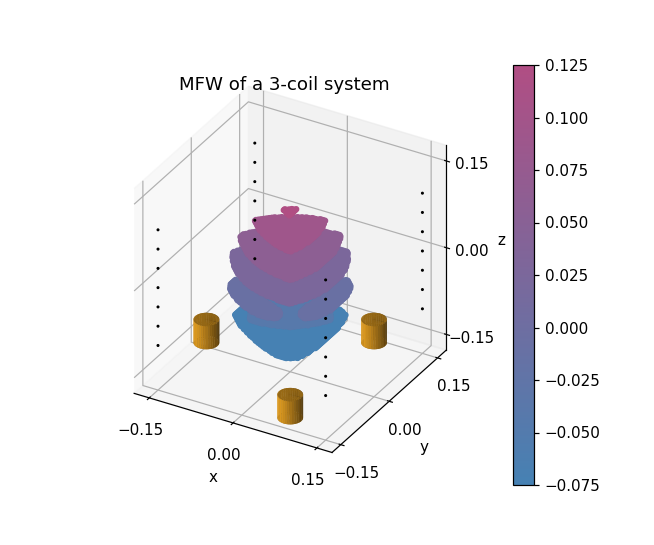

In [50]:
coil_length = 0.04
coil_radius = 0.02
lim = 0.17

fig = plt.figure(figsize=(6, 5))


ax = fig.gca(projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_2_in[:,0],p_ws_2_in[:,1],p_ws_2_in[:,2], alpha=1., s = 10, c=p_ws_2_in[:,2]-pmin[2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_2_side[:,0],p_ws_2_side[:,1],p_ws_2_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns2,ax)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('MFW of a 3-coil system')

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

plt.colorbar(s)

plt.show()

<IPython.core.display.Javascript object>


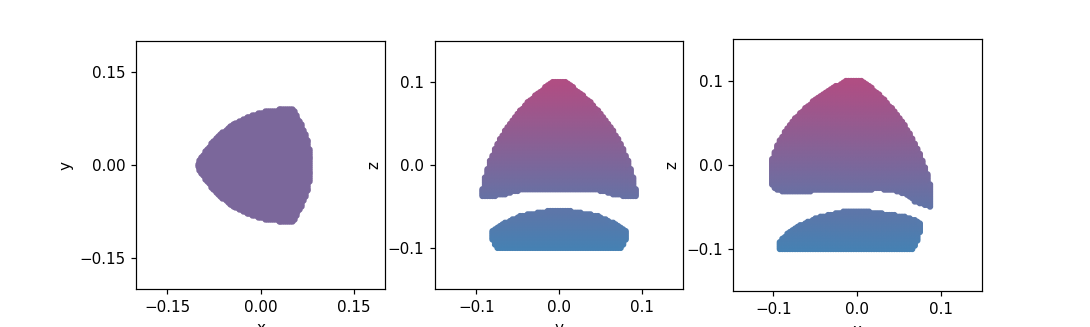

In [49]:
fig = plt.figure(figsize=(10, 3))

lim = 0.15


ax = fig.add_subplot(131)
ax.scatter(p_z_in[:,0],p_z_in[:,1],alpha=1., s = 10, color="#7B679B", rasterized=True)

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


ax = fig.add_subplot(132)
ax.scatter(p_x_in[:,1],p_x_in[:,2],alpha=1., s = 10, c=p_x_in[:,2]-pmin[2],cmap = newcmp, rasterized=True)

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_aspect('equal')
ax.set_xlabel('y')
ax.set_ylabel('z')

ax = fig.add_subplot(133)
ax.scatter(p_y_in[:,0],p_y_in[:,2],alpha=1., s = 10, c=p_y_in[:,2]-pmin[2],cmap = newcmp, rasterized=True)
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('z')

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_aspect('equal')

plt.show()


## Eight-coil system

In [68]:
# Load systems calibration
cal_path_mns3 = 'models/mns_8coils_octomag.yaml'
model3 = ForwardModelMPEM()
model3.setCalibrationFile(cal_path_mns3)

In [72]:
#Dimensions for coils representation
coil_length = 0.05
coil_radius = 0.015

Nx = 50
Ny = 50
Nz = 4

#Build initial box
pmin = [-0.1,-0.1,-0.025]
pmax = [0.1,0.1,0.085]

#Define inputs interval and task set
Imin = -1
Imax = 1

bmin = -0.09
bmax = 0.09

gmin = -0.5
gmax = 0.5

In [73]:
#Field
p_ws_3_field_in, p_ws_3_field_out, p_ws_3_field_side, kappa_3_field, mu_3_field, gci_3_field, ad_3_field = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model3,'ellipsoid')

In [74]:
#Gradient
p_ws_3_gradient_in, p_ws_3_gradient_out, p_ws_3_gradient_side, kappa_3_gradient, mu_3_gradient, gci_3_gradient, ad_3_gradient = Ws3DGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,gmin,gmax,Imin,Imax,model3,'ellipsoid')

In [75]:
#Field and gradient
p_ws_3_bg_in, p_ws_3_bg_out, p_ws_3_bg_side, kappa_3_bg, mu_3_bg, gci_3_bg, ad_3_bg = Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,-0.01,0.01,-0.05,0.05,-5,5,model3,'ellipsoid')

<IPython.core.display.Javascript object>


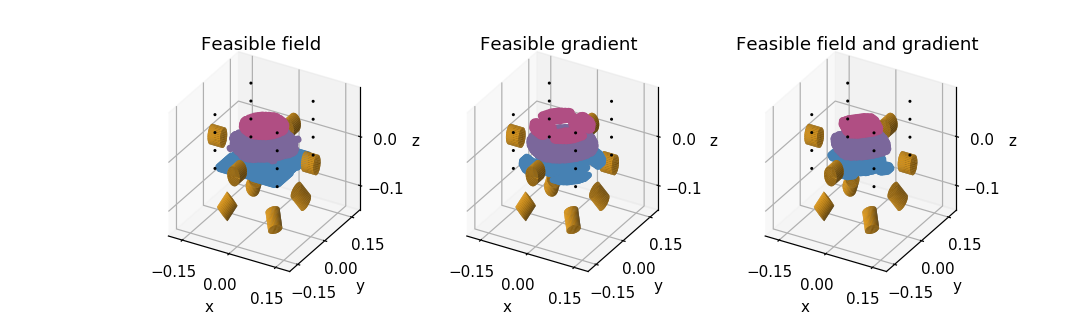

In [76]:
fig = plt.figure(figsize=(10,3))

coil_length = 0.04
coil_radius = 0.02

ax = fig.add_subplot(131,projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_3_field_in[:,0],p_ws_3_field_in[:,1],p_ws_3_field_in[:,2], alpha=1., s = 10, c=p_ws_3_field_in[:,2]-pmin[2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_3_field_side[:,0],p_ws_3_field_side[:,1],p_ws_3_field_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns3,ax,True)
ax.set_title('Feasible field')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(132,projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_3_gradient_in[:,0],p_ws_3_gradient_in[:,1],p_ws_3_gradient_in[:,2], alpha=1., s = 10, c=p_ws_3_gradient_in[:,2]-pmin[2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_3_gradient_side[:,0],p_ws_3_gradient_side[:,1],p_ws_3_gradient_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns3,ax,True)
ax.set_title('Feasible gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(133,projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_3_bg_in[:,0],p_ws_3_bg_in[:,1],p_ws_3_bg_in[:,2], alpha=1., s = 10, c=p_ws_3_bg_in[:,2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_3_bg_side[:,0],p_ws_3_bg_side[:,1],p_ws_3_bg_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns3,ax,True)
ax.set_title('Feasible field and gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

In [80]:
Nx = 1
Ny = 100
Nz = 100

#Build initial box
pmin = [0.,-0.1,-0.025]
pmax = [0.,0.1,0.085]

p_ws_3_field_x_in, p_ws_3_field_x_out, p_ws_3_field_x_side, kappa_3_field_x, mu_3_field_x, gci_3_field_x, ad_3_field_x = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model3,'ellipsoid')
p_ws_3_gradient_x_in, p_ws_3_gradient_x_out, p_ws_3_gradient_x_side, kappa_3_gradient_x, mu_3_gradient_x, gci_3_gradient_x, ad_3_gradient_x = Ws3DGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,gmin,gmax,Imin,Imax,model3,'ellipsoid')
p_ws_3_bg_x_in, p_ws_3_bg_x_out, p_ws_3_bg_x_side, kappa_3_bg_x, mu_3_bg_x, gci_3_bg_x, ad_3_bg_x = Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,-0.01,0.01,-0.05,0.05,-5,5,model3,'ellipsoid')

<IPython.core.display.Javascript object>


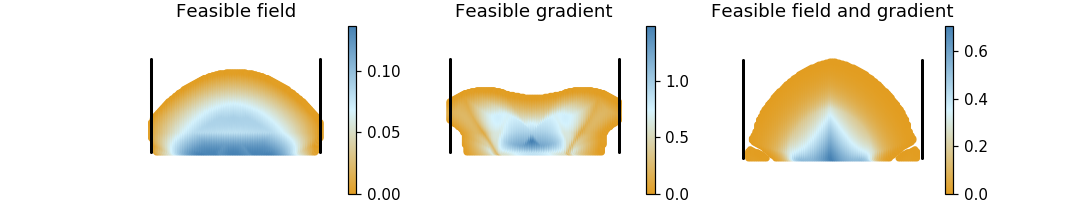

In [87]:
fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(131)
s = ax.scatter(p_ws_3_field_x_in[:,1],p_ws_3_field_x_in[:,2],alpha=1., s = 10, c=ad_3_field_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_field_x.max())
ax.scatter(p_ws_3_field_x_side[:,1],p_ws_3_field_x_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
ax.set_title('Feasible field')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(s, ticks=[0., 0.05, 0.1])
plt.show()
ax.axis('equal')
ax.axis('off')

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(132)
s = ax.scatter(p_ws_3_gradient_x_in[:,1],p_ws_3_gradient_x_in[:,2], alpha=1., s = 10, c=ad_3_gradient_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_gradient_x.max())
ax.scatter(p_ws_3_gradient_x_side[:,1],p_ws_3_gradient_x_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
ax.set_title('Feasible gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(s)
plt.show()
ax.axis('equal')
ax.axis('off')


ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(133)
s = ax.scatter(p_ws_3_bg_x_in[:,1],p_ws_3_bg_x_in[:,2], alpha=1., s = 10,  c=ad_3_bg_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_bg_x.max())
ax.scatter(p_ws_3_bg_x_side[:,1],p_ws_3_bg_x_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
ax.set_title('Feasible field and gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(s)
plt.show()
ax.axis('equal')
ax.axis('off')



ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))

## Application to the CardioMag eMNS

In [131]:
# Load system calibration
rp = rospkg.RosPack()
cal_path_cmag = os.path.join('models/C_Mag_Calibration_06-25-2015_no_offset.yaml')

model_cmag = ForwardModelMPEM()
model_cmag.setCalibrationFile(cal_path_cmag)

In [157]:
def ComputeMaxFieldWithZeroGradDicho(Nx,Ny,Nz,pmin,pmax,bmax,eps,Imin,Imax,model_mns):

    p_ws = np.empty((0,3))
    max_field_mT = np.array([])

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True) 


    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                J = model_mns.getActuationMatrix(position)

                #Check feasibility at each grid point            
                N, d = HyperPlaneShiftingMethod(J,Imin,Imax)
  
                
                tresh_max = bmax
                tresh_min = 0.
                btest = (tresh_max + tresh_min)/2
                
                while((tresh_max - tresh_min) >= eps):
                    btest = (tresh_max + tresh_min)/2
                    a = np.array([btest, btest, btest, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10])
                    isFeasible = VerifyFeasabilityEllipsoid(d,N,a)
                    
                    if isFeasible:
                        tresh_min = btest
                    else:
                        tresh_max = btest
                

                
                p_ws = np.append(p_ws, [position], axis=0)
                max_field_mT = np.append(max_field_mT, [btest*1000], axis=0)
                
      
    return p_ws, max_field_mT

In [177]:
#Define inputs interval and task set
Imin = -20
Imax = 20

eps = 0.00005

In [215]:
#Define requirements for catheter steering

Br = 1.3 #magnet remanence [T]
l = 5.0e-3 #magnet length [m]
d = 2.33e-3 #outer diameter [m]
mu0 = 4*math.pi*(10**(-7)) # permeability of vacuum [H/m]
m = (math.pi*(d/2)**2*l*Br)/mu0 #magnetic dipole moment [Nm/T]

theta_des = 120 * math.pi/180 # desired max tip angle [rad]
L = 4.0e-2 #length of the catheter [m]
E = 15.0e6 #Young's modulus of the catheter [Pa]
I = math.pi * (d/2)**4 /4 #second moment of area of the cross-section [m^4]

#Compute maximum torque and field magnitude
tmax = theta_des * E * I / L #[N.m]
bmax = tmax / m #[T]

print(tmax)
print(bmax)

0.0011362750330223654
0.05152028397410963


In [216]:
#Horizontal plane
Nx = 100
Ny = 100
Nz = 1

bmax_dicho = 0.12
p0 = np.array([-0.00851678, 0.03142507, 0.03213744]) #center of the mns frame

#Build initial box
pmin_hor = np.array([-0.15,-0.15,0.]) - p0
pmax_hor = np.array([0.15,0.15,0.]) - p0

p_hor, max_field_hor = ComputeMaxFieldWithZeroGradDicho(Nx,Ny,Nz,pmin_hor,pmax_hor,bmax_dicho,eps,Imin,Imax,model_cmag)

x_hor = np.linspace(pmin_hor[0], pmax_hor[0], 70, endpoint=True)
y_hor = np.linspace(pmin_hor[1], pmax_hor[1], 70, endpoint=True)
z_hor = griddata((p_hor[:,0], p_hor[:,1]), max_field_hor/1000, (x_hor[None,:], y_hor[:,None]), method='linear')

In [217]:
p_ws_3_bg_x_in, p_ws_3_bg_x_out, p_ws_3_bg_x_side, kappa_3_bg_x, mu_3_bg_x, gci_3_bg_x, ad_3_bg_x = Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin_hor,pmax_hor,-bmax,bmax,-1.e-10,1.e-10,-20,20,model_cmag,'ellipsoid')

<IPython.core.display.Javascript object>


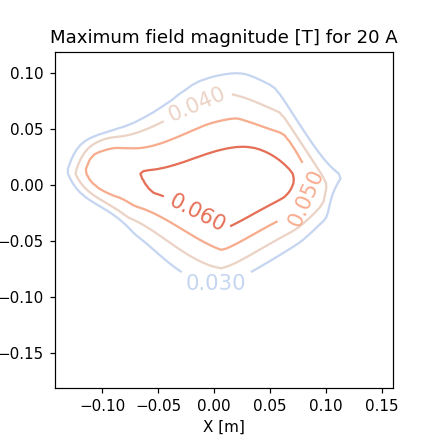

In [225]:
fig = plt.figure(figsize=(4, 4))

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor, [0.03, 0.04, 0.05, 0.06], cmap=cm.coolwarm, alpha=1., vmin=max_field_hor.min()/1000, vmax=max_field_hor.max()/1000)
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.3f')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('Maximum field magnitude [T] for 20 A')
ax.axis('equal')

plt.show()

<IPython.core.display.Javascript object>


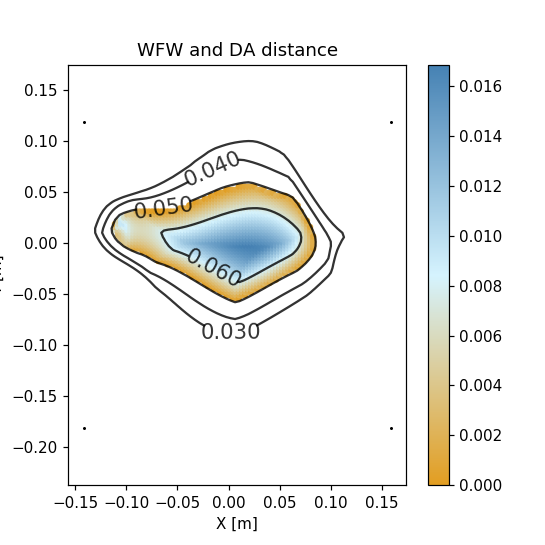

In [232]:
fig = plt.figure(figsize=(5, 5))

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor, [0.03, 0.04, 0.05, 0.06], alpha=0.8, colors='black', vmin=max_field_hor.min()/1000, vmax=max_field_hor.max()/1000)
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.3f')

s = ax.scatter(p_ws_3_bg_x_in[:,0],p_ws_3_bg_x_in[:,1],alpha=1., s = 10, c=ad_3_bg_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_bg_x.max())
ax.scatter(p_ws_3_bg_x_side[:,0],p_ws_3_bg_x_side[:,1], color='black',alpha=1., s = 1., rasterized=True)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('WFW and DA distance')
ax.axis('equal')

plt.colorbar(s)
plt.show()